# XGBoost Classifier training
- To reproduce these results, attach this notebook to a cluster with runtime version **14.3.x-gpu-ml-scala2.12**, and rerun it.

In [2]:
import mlflow
import databricks.automl_runtime

target_col = "Attack_type"

## Load Data

In [3]:
import mlflow
import os
import uuid
import shutil
import pandas as pd

# Create temp directory to download input data from MLflow
input_temp_dir = os.path.join(os.environ["SPARK_LOCAL_DIRS"], "tmp", str(uuid.uuid4())[:8])
os.makedirs(input_temp_dir)


# Download the artifact and read it into a pandas DataFrame
input_data_path = mlflow.artifacts.download_artifacts(run_id="72ad8924c4244502a9e4bfac23f077b8", artifact_path="data", dst_path=input_temp_dir)

df_loaded = pd.read_parquet(os.path.join(input_data_path, "training_data"))
# Delete the temp data
shutil.rmtree(input_temp_dir)

# Preview data
df_loaded.head(5)

,fwd_init_window_size,id_resp_p,fwd_pkts_payload_avg,fwd_pkts_payload_min,fwd_URG_flag_count,flow_SYN_flag_count,fwd_header_size_min,fwd_header_size_max,flow_pkts_payload_tot,flow_pkts_payload_max,...,service_mqtt,service_ntp,service_radius,service_ssl,service_unspec,proto_icmp,proto_tcp,proto_udp,Attack_type,_automl_split_col_0000
0,0.982193,0.107754,0.000707,0.000000,0.0,0.124948,0.908208,0.767880,0.000299,0.000977,...,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,NMAP_TCP_scan,train
1,0.981898,0.084867,0.000000,0.000000,0.0,0.124939,0.909971,0.384283,0.000335,0.000331,...,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,NMAP_TCP_scan,train
2,0.981881,0.112826,0.000503,0.000000,0.0,0.125522,0.905006,0.767794,0.000000,0.000000,...,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,NMAP_TCP_scan,train
3,0.984517,0.102880,0.000414,0.000137,0.0,0.125113,0.909074,0.768049,0.000425,0.000617,...,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,NMAP_TCP_scan,train
4,0.978233,0.001267,0.027654,0.000563,0.0,0.249913,0.727787,0.768948,0.000046,0.106685,...,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,NMAP_TCP_scan,train


### Select supported columns
Select only the columns that are supported. This allows us to train a model that can predict on a dataset that has extra columns that are not used in training.
`[]` are dropped in the pipelines. See the Alerts tab of the AutoML Experiment page for details on why these columns are dropped.

In [4]:
from databricks.automl_runtime.sklearn.column_selector import ColumnSelector
supported_cols = ["active_avg", "service_radius", "id_resp_p", "fwd_pkts_per_sec", "fwd_pkts_payload_avg", "id_orig_p", "flow_pkts_payload_tot", "service_dns", "fwd_header_size_tot", "service_dhcp", "flow_pkts_payload_min", "bwd_pkts_per_sec", "flow_pkts_per_sec", "active_min", "service_http", "fwd_header_size_max", "flow_pkts_payload_max", "bwd_pkts_payload_avg", "proto_tcp", "flow_SYN_flag_count", "service_mqtt", "fwd_header_size_min", "bwd_header_size_max", "fwd_pkts_payload_min", "fwd_iat_min", "service_unspec", "proto_udp", "flow_pkts_payload_avg", "fwd_URG_flag_count", "proto_icmp", "service_ssl", "flow_iat_min", "fwd_pkts_payload_tot", "fwd_last_window_size", "service_irc", "flow_FIN_flag_count", "payload_bytes_per_second", "fwd_init_window_size", "fwd_pkts_payload_max", "service_ntp"]
col_selector = ColumnSelector(supported_cols)

## Preprocessors

### Boolean columns
For each column, impute missing values and then convert into ones and zeros.

In [5]:
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import FunctionTransformer
from sklearn.preprocessing import OneHotEncoder as SklearnOneHotEncoder


bool_imputers = []

bool_pipeline = Pipeline(steps=[
    ("cast_type", FunctionTransformer(lambda df: df.astype(object))),
    ("imputers", ColumnTransformer(bool_imputers, remainder="passthrough")),
    ("onehot", SklearnOneHotEncoder(handle_unknown="ignore", drop="first")),
])

bool_transformers = [("boolean", bool_pipeline, ["proto_udp", "service_http", "service_irc", "fwd_URG_flag_count", "service_radius", "proto_icmp", "service_ssl", "service_dns", "proto_tcp", "service_mqtt", "service_dhcp", "service_ntp", "service_unspec"])]

### Numerical columns

Missing values for numerical columns are imputed with mean by default.

In [6]:
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import FunctionTransformer, StandardScaler

num_imputers = []
num_imputers.append(("impute_mean", SimpleImputer(), ["active_avg", "active_min", "bwd_header_size_max", "bwd_pkts_payload_avg", "bwd_pkts_per_sec", "flow_FIN_flag_count", "flow_SYN_flag_count", "flow_iat_min", "flow_pkts_payload_avg", "flow_pkts_payload_max", "flow_pkts_payload_min", "flow_pkts_payload_tot", "flow_pkts_per_sec", "fwd_URG_flag_count", "fwd_header_size_max", "fwd_header_size_min", "fwd_header_size_tot", "fwd_iat_min", "fwd_init_window_size", "fwd_last_window_size", "fwd_pkts_payload_avg", "fwd_pkts_payload_max", "fwd_pkts_payload_min", "fwd_pkts_payload_tot", "fwd_pkts_per_sec", "id_orig_p", "id_resp_p", "payload_bytes_per_second", "proto_icmp", "proto_tcp", "proto_udp", "service_dhcp", "service_dns", "service_http", "service_irc", "service_mqtt", "service_ntp", "service_radius", "service_ssl", "service_unspec"]))

numerical_pipeline = Pipeline(steps=[
    ("converter", FunctionTransformer(lambda df: df.apply(pd.to_numeric, errors='coerce'))),
    ("imputers", ColumnTransformer(num_imputers)),
    ("standardizer", StandardScaler()),
])

numerical_transformers = [("numerical", numerical_pipeline, ["active_avg", "id_resp_p", "fwd_pkts_payload_avg", "fwd_pkts_per_sec", "id_orig_p", "service_radius", "flow_pkts_payload_tot", "service_dns", "fwd_header_size_tot", "service_dhcp", "flow_pkts_payload_min", "bwd_pkts_per_sec", "flow_pkts_per_sec", "active_min", "service_http", "fwd_header_size_max", "flow_pkts_payload_max", "bwd_pkts_payload_avg", "flow_SYN_flag_count", "proto_tcp", "fwd_header_size_min", "service_mqtt", "bwd_header_size_max", "fwd_pkts_payload_min", "fwd_iat_min", "service_unspec", "flow_pkts_payload_avg", "proto_udp", "fwd_URG_flag_count", "proto_icmp", "service_ssl", "flow_iat_min", "fwd_pkts_payload_tot", "fwd_last_window_size", "service_irc", "flow_FIN_flag_count", "payload_bytes_per_second", "fwd_init_window_size", "fwd_pkts_payload_max", "service_ntp"])]

In [7]:
from sklearn.compose import ColumnTransformer

transformers = bool_transformers + numerical_transformers

preprocessor = ColumnTransformer(transformers, remainder="passthrough", sparse_threshold=0)

## Train - Validation - Test Split
The input data is split by AutoML into 3 sets:
- Train (60% of the dataset used to train the model)
- Validation (20% of the dataset used to tune the hyperparameters of the model)
- Test (20% of the dataset used to report the true performance of the model on an unseen dataset)

`_automl_split_col_0000` contains the information of which set a given row belongs to.
We use this column to split the dataset into the above 3 sets. 
The column should not be used for training so it is dropped after split is done.

In [8]:
# AutoML completed train - validation - test split internally and used _automl_split_col_0000 to specify the set
split_train_df = df_loaded.loc[df_loaded._automl_split_col_0000 == "train"]
split_val_df = df_loaded.loc[df_loaded._automl_split_col_0000 == "val"]
split_test_df = df_loaded.loc[df_loaded._automl_split_col_0000 == "test"]

# Separate target column from features and drop _automl_split_col_0000
X_train = split_train_df.drop([target_col, "_automl_split_col_0000"], axis=1)
y_train = split_train_df[target_col]

X_val = split_val_df.drop([target_col, "_automl_split_col_0000"], axis=1)
y_val = split_val_df[target_col]

X_test = split_test_df.drop([target_col, "_automl_split_col_0000"], axis=1)
y_test = split_test_df[target_col]

## Train classification model
- Log relevant metrics to MLflow to track runs
- All the runs are logged under [this MLflow experiment](#mlflow/experiments/2902357306527227)
- Change the model parameters and re-run the training cell to log a different trial to the MLflow experiment
- To view the full list of tunable hyperparameters, check the output of the cell below

In [9]:
from xgboost import XGBClassifier

help(XGBClassifier)

Help on class XGBClassifier in module xgboost.sklearn:

class XGBClassifier(XGBModel, sklearn.base.ClassifierMixin)
 |  XGBClassifier(*, objective: Union[str, Callable[[numpy.ndarray, numpy.ndarray], Tuple[numpy.ndarray, numpy.ndarray]], NoneType] = 'binary:logistic', use_label_encoder: Optional[bool] = None, **kwargs: Any) -> None
 |  
 |  Implementation of the scikit-learn API for XGBoost classification.
 |  
 |  
 |  Parameters
 |  ----------
 |  
 |      n_estimators : int
 |          Number of boosting rounds.
 |  
 |      max_depth :  Optional[int]
 |          Maximum tree depth for base learners.
 |      max_leaves :
 |          Maximum number of leaves; 0 indicates no limit.
 |      max_bin :
 |          If using histogram-based algorithm, maximum number of bins per feature
 |      grow_policy :
 |          Tree growing policy. 0: favor splitting at nodes closest to the node, i.e. grow
 |          depth-wise. 1: favor splitting at nodes with highest loss change.
 |      learnin

### Define the objective function
The objective function used to find optimal hyperparameters. By default, this notebook only runs
this function once (`max_evals=1` in the `hyperopt.fmin` invocation) with fixed hyperparameters, but
hyperparameters can be tuned by modifying `space`, defined below. `hyperopt.fmin` will then use this
function's return value to search the space to minimize the loss.

In [10]:
import mlflow
from mlflow.models import Model, infer_signature, ModelSignature
from mlflow.pyfunc import PyFuncModel
from mlflow import pyfunc
import sklearn
from sklearn import set_config
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import LabelEncoder
from databricks.automl_runtime.sklearn import TransformedTargetClassifier

from hyperopt import hp, tpe, fmin, STATUS_OK, Trials

# Create a separate pipeline to transform the validation dataset. This is used for early stopping.
mlflow.sklearn.autolog(disable=True)
pipeline_val = Pipeline([
    ("column_selector", col_selector),
    ("preprocessor", preprocessor),
])
pipeline_val.fit(X_train, y_train)
X_val_processed = pipeline_val.transform(X_val)
label_encoder_val = LabelEncoder()
label_encoder_val.fit(y_train)
y_val_processed = label_encoder_val.transform(y_val)

def objective(params):
  with mlflow.start_run(experiment_id="2902357306527227") as mlflow_run:
    xgbc_classifier = TransformedTargetClassifier(
        classifier=XGBClassifier(**params),
        transformer=LabelEncoder()  # XGBClassifier requires the target values to be integers between 0 and n_class-1
    )

    model = Pipeline([
        ("column_selector", col_selector),
        ("preprocessor", preprocessor),
        ("classifier", xgbc_classifier),
    ])

    # Enable automatic logging of input samples, metrics, parameters, and models
    mlflow.sklearn.autolog(
        log_input_examples=True,
        silent=True)

    model.fit(X_train, y_train, classifier__early_stopping_rounds=5, classifier__verbose=False, classifier__eval_set=[(X_val_processed,y_val_processed)])

    
    # Log metrics for the training set
    mlflow_model = Model()
    pyfunc.add_to_model(mlflow_model, loader_module="mlflow.sklearn")
    pyfunc_model = PyFuncModel(model_meta=mlflow_model, model_impl=model)
    training_eval_result = mlflow.evaluate(
        model=pyfunc_model,
        data=X_train.assign(**{str(target_col):y_train}),
        targets=target_col,
        model_type="classifier",
        evaluator_config = {"log_model_explainability": False,
                            "metric_prefix": "training_"  }
    )
    xgbc_training_metrics = training_eval_result.metrics
    # Log metrics for the validation set
    val_eval_result = mlflow.evaluate(
        model=pyfunc_model,
        data=X_val.assign(**{str(target_col):y_val}),
        targets=target_col,
        model_type="classifier",
        evaluator_config = {"log_model_explainability": False,
                            "metric_prefix": "val_"  }
    )
    xgbc_val_metrics = val_eval_result.metrics
    # Log metrics for the test set
    test_eval_result = mlflow.evaluate(
        model=pyfunc_model,
        data=X_test.assign(**{str(target_col):y_test}),
        targets=target_col,
        model_type="classifier",
        evaluator_config = {"log_model_explainability": False,
                            "metric_prefix": "test_"  }
    )
    xgbc_test_metrics = test_eval_result.metrics

    loss = -xgbc_val_metrics["val_f1_score"]

    # Truncate metric key names so they can be displayed together
    xgbc_val_metrics = {k.replace("val_", ""): v for k, v in xgbc_val_metrics.items()}
    xgbc_test_metrics = {k.replace("test_", ""): v for k, v in xgbc_test_metrics.items()}

    return {
      "loss": loss,
      "status": STATUS_OK,
      "val_metrics": xgbc_val_metrics,
      "test_metrics": xgbc_test_metrics,
      "model": model,
      "run": mlflow_run,
    }

### Configure the hyperparameter search space
Configure the search space of parameters. Parameters below are all constant expressions but can be
modified to widen the search space. For example, when training a decision tree classifier, to allow
the maximum tree depth to be either 2 or 3, set the key of 'max_depth' to
`hp.choice('max_depth', [2, 3])`. Be sure to also increase `max_evals` in the `fmin` call below.

See https://docs.databricks.com/applications/machine-learning/automl-hyperparam-tuning/index.html
for more information on hyperparameter tuning as well as
http://hyperopt.github.io/hyperopt/getting-started/search_spaces/ for documentation on supported
search expressions.

For documentation on parameters used by the model in use, please see:
https://xgboost.readthedocs.io/en/stable/python/python_api.html#xgboost.XGBClassifier

NOTE: The above URL points to a stable version of the documentation corresponding to the last
released version of the package. The documentation may differ slightly for the package version
used by this notebook.

In [11]:
space = {
  "colsample_bytree": 0.3063256992113419,
  "learning_rate": 0.04798063839408549,
  "max_depth": 8,
  "min_child_weight": 11,
  "n_estimators": 2321,
  "n_jobs": 100,
  "subsample": 0.6114802381239415,
  "verbosity": 0,
  "random_state": 536650434,
}

### Run trials
When widening the search space and training multiple models, switch to `SparkTrials` to parallelize
training on Spark:
```
from hyperopt import SparkTrials
trials = SparkTrials()
```

NOTE: While `Trials` starts an MLFlow run for each set of hyperparameters, `SparkTrials` only starts
one top-level run; it will start a subrun for each set of hyperparameters.

See http://hyperopt.github.io/hyperopt/scaleout/spark/ for more info.

In [12]:
trials = Trials()
fmin(objective,
     space=space,
     algo=tpe.suggest,
     max_evals=1,  # Increase this when widening the hyperparameter search space.
     trials=trials)

best_result = trials.best_trial["result"]
model = best_result["model"]
mlflow_run = best_result["run"]

display(
  pd.DataFrame(
    [best_result["val_metrics"], best_result["test_metrics"]],
    index=["validation", "test"]))

set_config(display="diagram")
model

  0%|          | 0/1 [00:00<?, ?trial/s, best loss=?]

/databricks/python/lib/python3.10/site-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



WARN StatusConsoleListener The use of package scanning to locate plugins is deprecated and will be removed in a future release
WARN StatusConsoleListener The use of package scanning to locate plugins is deprecated and will be removed in a future release
WARN StatusConsoleListener The use of package scanning to locate plugins is deprecated and will be removed in a future release
WARN StatusConsoleListener The use of package scanning to locate plugins is deprecated and will be removed in a future release
WARN StatusConsoleListener RollingFileAppender 'publicFile.rolling': The bufferSize is set to 8192 but bufferedIO is not true
WARN StatusConsoleListener RollingFileAppender 'privateFile.rolling': The bufferSize is set to 8192 but bufferedIO is not true
WARN StatusConsoleListener RollingFileAppender 'com.databricks.UsageLogging.appender': The bufferSize is set to 8192 but bufferedIO is not true
WARN StatusConsoleListener RollingFileAppender 'com.databricks.EventLoggingStats.appender': The

Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).


Uploading artifacts:   0%|          | 0/1 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/6 [00:00<?, ?it/s]

2024/03/10 00:02:17 INFO mlflow.models.evaluation.base: Evaluating the model with the default evaluator.

2024/03/10 00:02:17 INFO mlflow.models.evaluation.default_evaluator: Computing model predictions.

2024/03/10 00:02:23 INFO mlflow.models.evaluation.default_evaluator: The evaluation dataset is inferred as multiclass dataset, number of classes is inferred as 10

2024/03/10 00:02:32 INFO mlflow.models.evaluation.default_evaluator: Testing metrics on first row...

2024/03/10 00:02:44 INFO mlflow.models.evaluation.base: Evaluating the model with the default evaluator.

2024/03/10 00:02:44 INFO mlflow.models.evaluation.default_evaluator: Computing model predictions.

2024/03/10 00:02:46 INFO mlflow.models.evaluation.default_evaluator: The evaluation dataset is inferred as multiclass dataset, number of classes is inferred as 10

2024/03/10 00:02:49 INFO mlflow.models.evaluation.default_evaluator: Testing metrics on first row...

2024/03/10 00:02:59 INFO mlflow.models.evaluation.base: Ev

100%|██████████| 1/1 [13:13<00:00, 793.35s/trial, best loss: -0.8835044526879332]


,score,example_count,accuracy_score,recall_score,precision_score,f1_score,log_loss,roc_auc
validation,0.883179,21212,0.883179,0.883179,0.884594,0.883504,0.333803,0.992891
test,0.887856,21187,0.887856,0.887856,0.889250,0.888177,0.327089,0.993116


Pipeline(steps=[('column_selector',
                 ColumnSelector(cols=['active_avg', 'service_radius',
                                      'id_resp_p', 'fwd_pkts_per_sec',
                                      'fwd_pkts_payload_avg', 'id_orig_p',
                                      'flow_pkts_payload_tot', 'service_dns',
                                      'fwd_header_size_tot', 'service_dhcp',
                                      'flow_pkts_payload_min',
                                      'bwd_pkts_per_sec', 'flow_pkts_per_sec',
                                      'active_min', 'service_http',
                                      'fwd_header_size_max',
                                      'flow_pkts...
                                                                      interaction_constraints=None,
                                                                      learning_rate=0.04798063839408549,
                                                                      max_bin=None,
                                                                      max_cat_threshold=None,
                                                                      max_cat_to_onehot=None,
                                                                      max_delta_step=None,
                                                                      max_depth=8,
                                                                      max_leaves=None,
                                                                      min_child_weight=11,
                                                                      missing=nan,
                                                                      monotone_constraints=None,
                                                                      n_estimators=2321,
                                                                      n_jobs=100,
                                                                      num_parallel_tree=None,
                                                                      objective='multi:softprob',
                                                                      predictor=None, ...),
                                             transformer=LabelEncoder()))])

<Figure size 1050x700 with 0 Axes>

### Patch pandas version in logged model

Ensures that model serving uses the same version of pandas that was used to train the model.

In [13]:
import mlflow
import os
import shutil
import tempfile
import yaml

run_id = mlflow_run.info.run_id

# Set up a local dir for downloading the artifacts.
tmp_dir = tempfile.mkdtemp()

client = mlflow.tracking.MlflowClient()

# Fix conda.yaml
conda_file_path = mlflow.artifacts.download_artifacts(artifact_uri=f"runs:/{run_id}/model/conda.yaml", dst_path=tmp_dir)
with open(conda_file_path) as f:
  conda_libs = yaml.load(f, Loader=yaml.FullLoader)
pandas_lib_exists = any([lib.startswith("pandas==") for lib in conda_libs["dependencies"][-1]["pip"]])
if not pandas_lib_exists:
  print("Adding pandas dependency to conda.yaml")
  conda_libs["dependencies"][-1]["pip"].append(f"pandas=={pd.__version__}")

  with open(f"{tmp_dir}/conda.yaml", "w") as f:
    f.write(yaml.dump(conda_libs))
  client.log_artifact(run_id=run_id, local_path=conda_file_path, artifact_path="model")

# Fix requirements.txt
venv_file_path = mlflow.artifacts.download_artifacts(artifact_uri=f"runs:/{run_id}/model/requirements.txt", dst_path=tmp_dir)
with open(venv_file_path) as f:
  venv_libs = f.readlines()
venv_libs = [lib.strip() for lib in venv_libs]
pandas_lib_exists = any([lib.startswith("pandas==") for lib in venv_libs])
if not pandas_lib_exists:
  print("Adding pandas dependency to requirements.txt")
  venv_libs.append(f"pandas=={pd.__version__}")

  with open(f"{tmp_dir}/requirements.txt", "w") as f:
    f.write("\n".join(venv_libs))
  client.log_artifact(run_id=run_id, local_path=venv_file_path, artifact_path="model")

shutil.rmtree(tmp_dir)

Adding pandas dependency to conda.yaml


Adding pandas dependency to requirements.txt


## Feature importance

SHAP is a game-theoretic approach to explain machine learning models, providing a summary plot
of the relationship between features and model output. Features are ranked in descending order of
importance, and impact/color describe the correlation between the feature and the target variable.
- Generating SHAP feature importance is a very memory intensive operation, so to ensure that AutoML can run trials without
  running out of memory, we disable SHAP by default.<br />
  You can set the flag defined below to `shap_enabled = True` and re-run this notebook to see the SHAP plots.
- To reduce the computational overhead of each trial, a single example is sampled from the validation set to explain.<br />
  For more thorough results, increase the sample size of explanations, or provide your own examples to explain.
- SHAP cannot explain models using data with nulls; if your dataset has any, both the background data and
  examples to explain will be imputed using the mode (most frequent values). This affects the computed
  SHAP values, as the imputed samples may not match the actual data distribution.

For more information on how to read Shapley values, see the [SHAP documentation](https://shap.readthedocs.io/en/latest/example_notebooks/overviews/An%20introduction%20to%20explainable%20AI%20with%20Shapley%20values.html).

In [14]:
# Set this flag to True and re-run the notebook to see the SHAP plots
shap_enabled = False

In [15]:
if shap_enabled:
    mlflow.autolog(disable=True)
    mlflow.sklearn.autolog(disable=True)
    from shap import KernelExplainer, summary_plot
    # Sample background data for SHAP Explainer. Increase the sample size to reduce variance.
    train_sample = X_train.sample(n=min(100, X_train.shape[0]), random_state=536650434)

    # Sample some rows from the validation set to explain. Increase the sample size for more thorough results.
    example = X_val.sample(n=min(100, X_val.shape[0]), random_state=536650434)

    # Use Kernel SHAP to explain feature importance on the sampled rows from the validation set.
    predict = lambda x: model.predict_proba(pd.DataFrame(x, columns=X_train.columns))
    explainer = KernelExplainer(predict, train_sample, link="logit")
    shap_values = explainer.shap_values(example, l1_reg=False, nsamples=500)
    summary_plot(shap_values, example, class_names=model.classes_)

## Inference
[The MLflow Model Registry](https://docs.databricks.com/applications/mlflow/model-registry.html) is a collaborative hub where teams can share ML models, work together from experimentation to online testing and production, integrate with approval and governance workflows, and monitor ML deployments and their performance. The snippets below show how to add the model trained in this notebook to the model registry and to retrieve it later for inference.

> **NOTE:** The `model_uri` for the model already trained in this notebook can be found in the cell below

### Register to Model Registry
```
model_name = "Example"

model_uri = f"runs:/{ mlflow_run.info.run_id }/model"
registered_model_version = mlflow.register_model(model_uri, model_name)
```

### Load from Model Registry
```
model_name = "Example"
model_version = registered_model_version.version

model_uri=f"models:/{model_name}/{model_version}"
model = mlflow.pyfunc.load_model(model_uri=model_uri)
model.predict(input_X)
```

### Load model without registering
```
model_uri = f"runs:/{ mlflow_run.info.run_id }/model"

model = mlflow.pyfunc.load_model(model_uri=model_uri)
model.predict(input_X)
```

In [16]:
# model_uri for the generated model
print(f"runs:/{ mlflow_run.info.run_id }/model")

runs:/74a7f0bdd560471eb56420fc8047aee1/model


## Confusion matrix for validation data

We show the confusion matrix of the model on the validation data.

For the plots evaluated on the training and the test data, check the artifacts on the MLflow run page.

In [17]:
# Click the link to see the MLflow run page
displayHTML(f"<a href=#mlflow/experiments/2902357306527227/runs/{ mlflow_run.info.run_id }/artifactPath/model> Link to model run page </a>")

In [18]:
import uuid
from IPython.display import Image

# Create temp directory to download MLflow model artifact
eval_temp_dir = os.path.join(os.environ["SPARK_LOCAL_DIRS"], "tmp", str(uuid.uuid4())[:8])
os.makedirs(eval_temp_dir, exist_ok=True)

# Download the artifact
eval_path = mlflow.artifacts.download_artifacts(run_id=mlflow_run.info.run_id, dst_path=eval_temp_dir)

2024/03/10 00:03:21 INFO mlflow.store.artifact.artifact_repo: The progress bar can be disabled by setting the environment variable MLFLOW_ENABLE_ARTIFACTS_PROGRESS_BAR to false


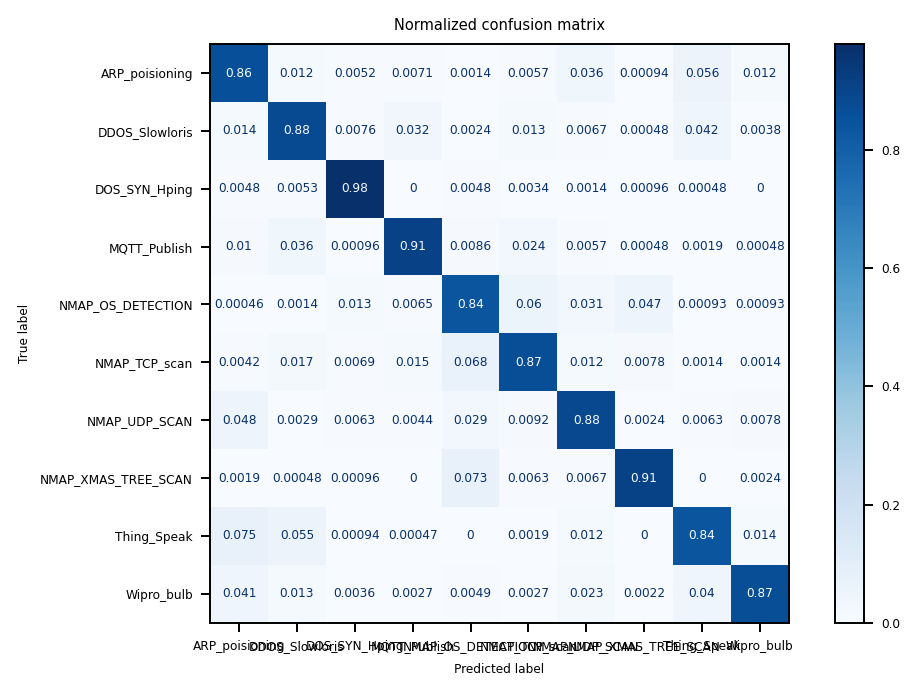

In [19]:
eval_confusion_matrix_path = os.path.join(eval_path, "val_confusion_matrix.png")
display(Image(filename=eval_confusion_matrix_path))